## Hopfield network - part 1: memory storage and retrieval

Build a Hopfield network with $nunits$ neurons, storing $npatterns$ orthogonal patterns in its synaptic weights.

Neurons activity takes values $S_i=\{\pm1\}$, for $i=1,\ldots,nunits$.

Input patterns take values $\xi_i^\mu=\{\pm1\}$, for $i=1,\ldots,nunits$ neurons and $\mu=1,\ldots,npatterns$ patterns.

Test memory retrieval and the occurrence of spurious states 


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
np.random.seed(1)

# plotting specifications
#Options
params = {'text.usetex' : True,
         'font.size' : 20,
         'font.family' : 'cmr10',
#          'figure.autolayout': True
         }
plt.rcParams.update(params)
# plt.rcParams['axes.unicode_minus']=False
# plt.rcParams['axes.labelsize']=16
# plt.rcParams['figure.figsize']=(5,5)

cmap = plt.get_cmap("tab10") # default color cycle, call by using color=cmap(i) i=0 is blue
#reversed('RdBu')

Create $npatterns=4$ orthogonal patterns $\xi_i^\mu$. We visualize neurons on a square grid.

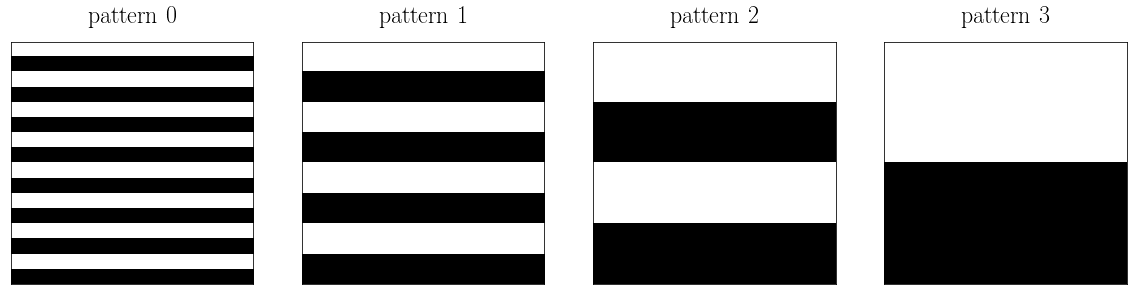

In [7]:
N1=16; # size of edge of square array
nunits=N1**2 # neurons
npatterns=4

def generate_orth_patterns(nunits,npatterns):
    train_data=np.zeros((npatterns,nunits))
    N1=int(nunits**(1/2))
    for ip in range(npatterns):
        tempPattern=-np.ones((N1,N1))
        for i in range(N1):
            if (np.ceil((i+1)/(2**ip)) % 2 ==0):
                tempPattern[i,:]=1 # top left to bottom right
        train_data[ip,:]=tempPattern.flatten()
    return train_data
    
def generate_rand_patterns(nunits,npatterns,probFlip):
    #probFlip=probability of having +1 entry
    train_data=-np.ones((npatterns,nunits))
    N1=int(nunits**(1/2))
    for ip in range(npatterns):
        tempPattern=-np.ones(nunits)
        indflip=(np.random.rand(nunits)<probFlip)
        tempPattern[indflip]=1
        train_data[ip,:]=tempPattern.flatten()
    return train_data

# plot patterns
def plotpattern(pattern,ax,title='pattern'):
    ax.matshow(np.reshape(pattern,[N1,N1]), cmap='Greys',interpolation='nearest')
    ax.set_xticks([]); ax.set_yticks([]); ax.set_title(title)
    
train_data=generate_orth_patterns(nunits,npatterns)    
# train_data=generate_rand_patterns(nunits,npatterns,0.1)    

nplot=len(train_data)
fig,ax=plt.subplots(1,nplot,figsize=(20,5))
for i in range(nplot):
    plotpattern(train_data[i],ax[i],title='pattern %s' % i)
plt.savefig("orthogonal_patterns4.png")

Compute overlaps $m_{\mu\nu}$ between patterns (correlation): check that patterns are orthogonal.

$$
m_{\mu\nu}={1\over N}\sum_{i=1}^N\xi_i^\mu\xi_i^\nu \ .
$$


In [8]:
def compute_overlap(pattern1,pattern2):
    # returns: overlap between the patterns
    shape1=pattern1.shape
    if shape1 !=pattern2.shape:
        raise ValueError("patterns have different shape!")
    dot_prod=np.dot(pattern1.flatten(),pattern2.flatten())
    return float(dot_prod)/np.prod(shape1)

def compute_overlap_list(reference_pattern,pattern_list):
    overlap=np.zeros(len(pattern_list))
    for i in range(0,len(pattern_list)):
        overlap[i]=compute_overlap(reference_pattern,pattern_list[i])
    return overlap

def compute_overlap_matrix(pattern_list):
    nr_patterns=len(pattern_list)
    overlap=np.zeros((nr_patterns,nr_patterns))
    for i in range(nr_patterns):
        for k in range(i+1):
            if i==k:
                overlap[i,i]=1
            else:
                overlap[i,k]=compute_overlap(pattern_list[i],pattern_list[k])
                overlap[k,i]=overlap[i,k]
    return overlap

overlap=compute_overlap(train_data[0],train_data[1])
print(overlap)
overlap=compute_overlap_list(train_data[0],train_data)
print(overlap)
overlap=compute_overlap_matrix(train_data)
print(overlap)

0.0
[1. 0. 0. 0.]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


Store first pattern in the synaptic weights $w_{ij}$:

$$
w_{ij}={1\over N}\xi^\mu_i\xi^\mu_j-{1\over N}\delta_{ij} \ ,
$$
where the last term enforces $w_{ii}=0$.

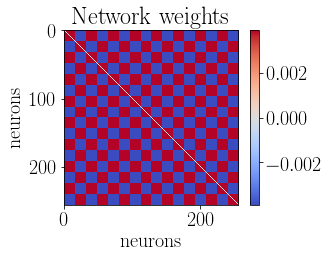

In [9]:
# hebb rule
weights0=np.outer(train_data[0],train_data[0])/nunits
np.fill_diagonal(weights0,0)

def plotweights(self,file="current_weight.png"):
    plt.figure(figsize=(5,4))
    w_plot=plt.imshow(self,cmap=cm.coolwarm)
    plt.colorbar(w_plot)
    plt.title("Network weights")
    plt.xlabel("neurons"); plt.ylabel("neurons"); plt.tight_layout(); plt.savefig(file)
    plt.show()
    
plotweights(weights0)

## Recurrent dynamics

Implement Hopfield network dynamics, using two different kinds of updates. Monitor the network energy function (Lyapunov function of the dynamics, monotonically decreasing):
$$
E=-{1\over2}\sum_{i,j}w_{ij}S_iS_j \ ,
$$

1. Asynchronous updates at zero temperature. At each time step, pick a random neuron and update its value according to the rule:

$$
S_i(t+1)=sign[\,h_i(t)+\theta_i\,] \ ,
$$ 
where $h_i(t)=\sum_{j=1}^N w_{ij}S_j(t)$ is the neuron's input and $\theta_i$ is an activation threshold.

2. Asynchronous updates with nonzero temperature $T$. At each time step, pick a random neuron and update its value according to the probabilistic rule:

$$
Prob[S_i(t+1)=+1]={1\over 1+e^{-2\beta (h_i(t)+\theta_i)}} \ ,
$$ 
where $h_i(t)=\sum_{j=1}^N w_{ij}S_j(t)$ is the neuron's input and $\theta_i$ is an activation threshold. $\beta=1/T$ is the inverse temperature.

In [51]:
# dynamics
def probspin(h,beta):
    res=1/(1+np.exp(-2*beta*h))
    return res

def flow(pattern,weights,theta=0.,steps=100,display=True,EarlyStop=True,T=0):
    nunits=len(pattern)
    steps_tot=steps*nunits
    pattern_flat=pattern.flatten()
    energy=[]
    if (type(theta)==float) or (type(theta)==int):
        thetas=np.zeros(len(pattern_flat))+theta
    for step in range(steps_tot):
        units_perm=np.random.permutation(len(pattern_flat))
        for unit1 in units_perm:
            # unit1=np.random.randint(low=0,high=(len(pattern_flat)))
            unit_weights=weights[unit1,:]
            net_input=np.dot(unit_weights,pattern_flat)
            if T==0:
                pattern_flat[unit1]=1 if (net_input>thetas[unit1]) else -1
            else:
                pattern_flat[unit1]=1 if probspin(net_input-thetas[unit1],1/T)>np.random.rand(1) else -1
        energytemp=-0.5*np.dot(np.dot(pattern_flat.T,weights),pattern_flat)
        energy.append(energytemp)
        if display:
            print('energy at step {} is now {}'.format((step),energytemp))
        if (step>0) & EarlyStop:
            TOL=np.diff(energy[-nunits*5:-1]).sum()
            if (TOL==0):
                # monitors changes in energy values, stop dynamics if no change in last 5 steps
                if display:
                    print('reached min of energy, stop dynamics!')
                break
    evolved_pattern=pattern_flat
    return evolved_pattern


## Memory retrieval

Introduce a corrupt version $\rho^{\mu}_i(p)$ of the stored pattern $\xi^\mu_i$, where we flip a fraction $p$=flip_fraction of the pattern bits.  

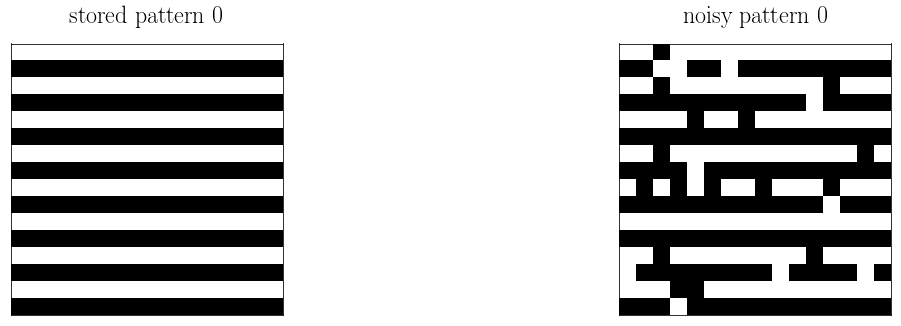

In [52]:
# def noisify(pattern,flip_fraction):
def noisify(pattern,flip_fraction):
    noisy_pattern=pattern.copy()
    lenpat=len(noisy_pattern)
    choices=np.random.choice(lenpat,int(round(flip_fraction*lenpat)),replace=False)
    noisy_pattern[choices]=-noisy_pattern[choices]
    return noisy_pattern

noisy0=noisify(train_data[0],0.1)
fig,ax=plt.subplots(1,2,figsize=(20,5))
plotpattern(train_data[0],ax[0],title='stored pattern 0')
plotpattern(noisy0,ax[1],title='noisy pattern 0')


Use the corrupt pattern $S_i(0)=\rho^{\mu}_i(p)$ as initial condition for the network dynamics. Does the network converge? Try to increase the fraction of bits flipped. When does retrieval stop working? 

Use the negative corrupt pattern $S_i(0)=-\rho^{\mu}_i(p)$ as initial condition, and let the network evolve. Where does the network converge to? 

overlap of noisy pattern with 4 patterns [0.203125 0.015625 0.09375  0.015625]

energy at step 0 is now -127.5
energy at step 1 is now -127.5
reached min of energy, stop dynamics!
overlap of retrieved pattern with 4 patterns [1. 0. 0. 0.]

overlap of noisy pattern with 4 patterns [-0.203125 -0.015625 -0.09375  -0.015625]

energy at step 0 is now -127.5
energy at step 1 is now -127.5
reached min of energy, stop dynamics!
overlap of retrieved pattern with 4 patterns [-1.  0.  0.  0.]



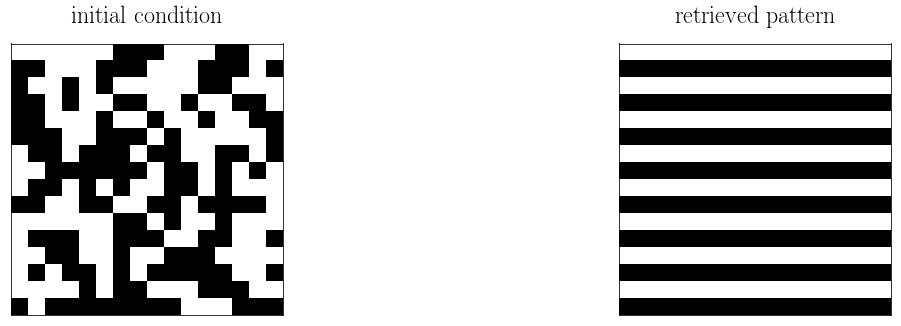

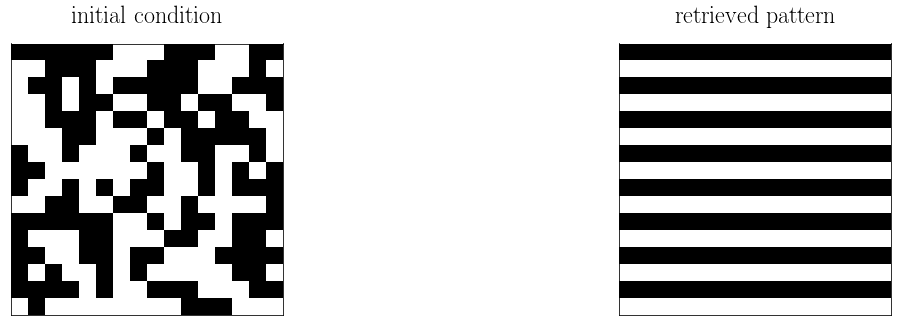

In [53]:
noisy0=noisify(train_data[0],0.4)

overlap=compute_overlap_list(noisy0,train_data)
# evolve corrupt version of 1st pattern
print('overlap of noisy pattern with 4 patterns %s\n' % overlap)
noisy_evolved0=flow(noisy0,weights0,theta=0,steps=100)
overlap=compute_overlap_list(noisy_evolved0,train_data)
print('overlap of retrieved pattern with 4 patterns %s\n' % overlap)
fig,ax=plt.subplots(1,2,figsize=(20,5))
plotpattern(noisy0,ax[0],title='initial condition')
plotpattern(noisy_evolved0,ax[1],title='retrieved pattern')

overlap=compute_overlap_list(-noisy0,train_data)
# evolve corrupt version of 1st pattern
print('overlap of noisy pattern with 4 patterns %s\n' % overlap)
noisy_evolved0=flow(-noisy0,weights0,theta=0,steps=100)
overlap=compute_overlap_list(noisy_evolved0,train_data)
print('overlap of retrieved pattern with 4 patterns %s\n' % overlap)
fig,ax=plt.subplots(1,2,figsize=(20,5))
plotpattern(-noisy0,ax[0],title='initial condition')
plotpattern(noisy_evolved0,ax[1],title='retrieved pattern')


## Basin of attraction

Calculate the basin of attraction of the pattern $\xi^\mu_i$, defined as value of the overlap $m[\xi^\mu_i,\rho^{\mu}_i(p)]$ for which pattern retrieval goes down to chance level. For each value of spin flip percentage $p$, run 5 times from random initial conditions and story the fraction of correctly retrieved patterns. 

Hint: calculate retrieval by increasing the percentage of spin flips $p$ of the corrupt initial condition $\rho^{\mu}_i(p)$.


In [54]:
# i_train is the index of the pattern that we choose for noisyfied initial conditions and try to retrieve
def basin(testpatterns,i_train,weights1,fset,nrepeats,T=0):


    print(overlap_f)
    print(retrieval_f)


    fig,ax=plt.subplots(1,1,figsize=(10,5))
    ax.plot(overlap_f, retrieval_f, linestyle='solid')
    ax.set_title("pattern retrieval")
    ax.set_xlabel("overlap m"); ax.set_ylabel("successful retrieval [%]")
    ax.plot([overlap_f.min(),overlap_f.max()],0.5*np.ones(2))

    return overlap_f,retrieval_f

basin(test_patterns,0,weights0,fset,nrepeats)

NameError: name 'test_patterns' is not defined

Store all patterns now, check we recover all of them.

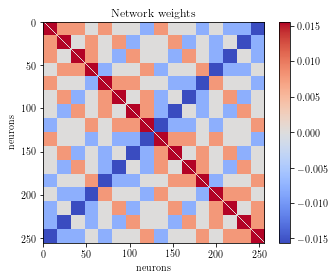

[-0.1171875  0.0078125 -0.1796875  0.1015625]
[0.0859375 0.1328125 0.2109375 0.0234375]
[ 0.015625 -0.015625  0.296875  0.03125 ]
[-0.09375  -0.0625    0.0625   -0.046875]


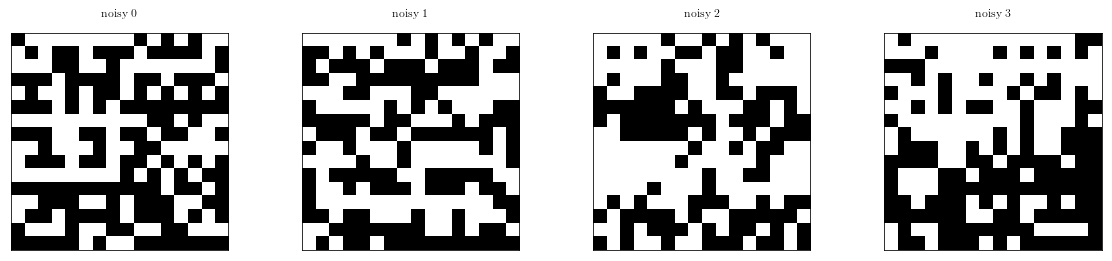

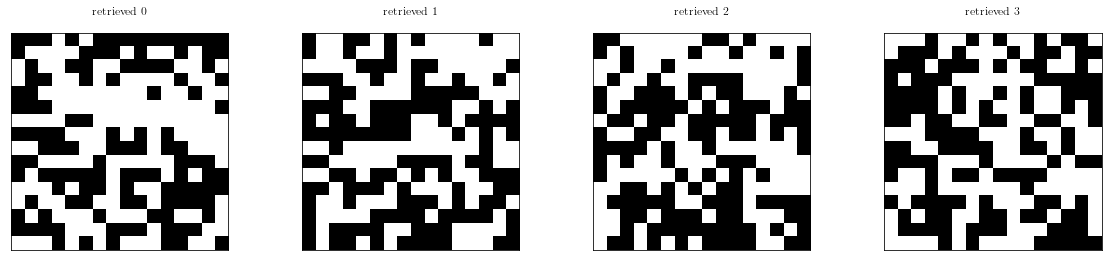

In [17]:
plotweights(allweights)

# noisify each pattern


fig,ax=plt.subplots(1,4,figsize=(20,4))
for i in range(npatterns):
    plotpattern(noisy_patterns[i],ax[i],title='noisy %s' % i)

plt.savefig("hopfield_orth4_noisy.png")

fig,ax=plt.subplots(1,4,figsize=(20,4))
for i in range(npatterns):
    plotpattern(recovered_pattern[i],ax[i],title='retrieved %s' % i)
plt.savefig("hopfield_orth4_retrieval.png")

## Equidistant initial conditions
An initial state that has equal overlap with both patterns ends up in either attractor randomly, 
because asynchronous updates introduce stochasticity.

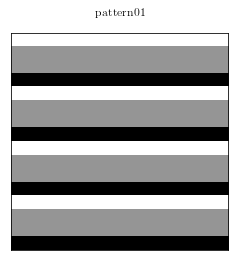

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(6,4))
plotpattern(pattern01,ax,title='pattern01')
# print('overlaps %s' % overlap)

Run dynamics 10 times and plot retrieved patterns.

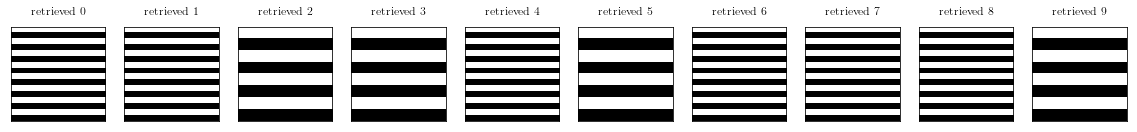

In [ ]:


fig,ax=plt.subplots(1,10,figsize=(20,4))
for i in range(10):
    plotpattern(recovered_pattern[i],ax[i],title='retrieved %s' % i)


## Temperature and basins of attraction

Check basins of attraction shrink when we increase T

Check that basins of attraction shrink when we increase the number of stored patterns

nunits 256
[ 1.         0.78125    0.5546875  0.3359375  0.109375  -0.109375
 -0.3359375 -0.5546875 -0.78125   -1.       ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


(array([ 1.       ,  0.78125  ,  0.5546875,  0.3359375,  0.109375 ,
        -0.109375 , -0.3359375, -0.5546875, -0.78125  , -1.       ]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

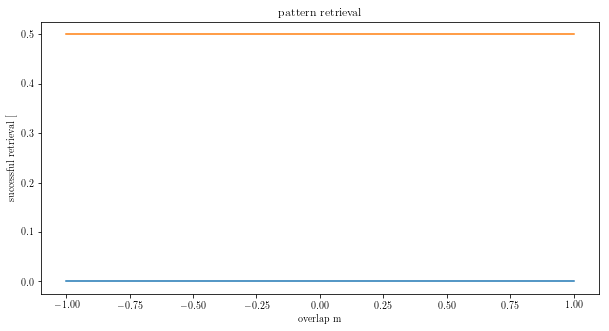

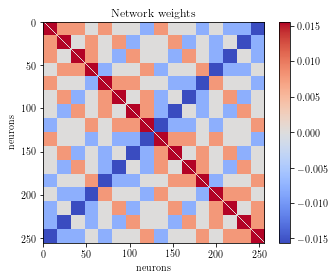

Spurious state: combination of 3 patterns!

overlap with spurious [ 0.5 -0.5  0.5  0. ]
energy at step 00000 is now -63.53125
energy at step 00200 is now -78.875
energy at step 00400 is now -83.78125
energy at step 00600 is now -92.0625
energy at step 00800 is now -92.0625
energy at step 01000 is now -92.0625
energy at step 01200 is now -94.0
energy at step 01400 is now -94.0
energy at step 01600 is now -94.0
energy at step 01800 is now -94.0
energy at step 02000 is now -94.0
reached min of energy, stop dynamics
[ 0.5 -0.5  0.5  0. ]


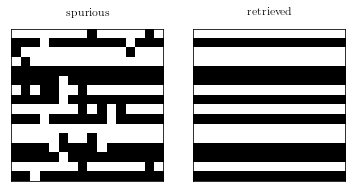

In [34]:

# plot patterns
fig,ax=plt.subplots(1,2,figsize=(6,4))
plotpattern(spurious0,ax[0],title='spurious')
plotpattern(recovered_pattern,ax[1],title='retrieved')
plt.savefig("hopfield_orth_spurious.png")
overlap=compute_overlap_list(recovered_pattern,train_data)
print(overlap)

[ 1.         0.78125    0.5546875  0.3359375  0.109375  -0.109375
 -0.3359375 -0.5546875 -0.78125   -1.       ]
[1.  1.  1.  1.  1.  0.6 0.4 0.  0.  0. ]


(array([ 1.       ,  0.78125  ,  0.5546875,  0.3359375,  0.109375 ,
        -0.109375 , -0.3359375, -0.5546875, -0.78125  , -1.       ]),
 array([1. , 1. , 1. , 1. , 1. , 0.6, 0.4, 0. , 0. , 0. ]))

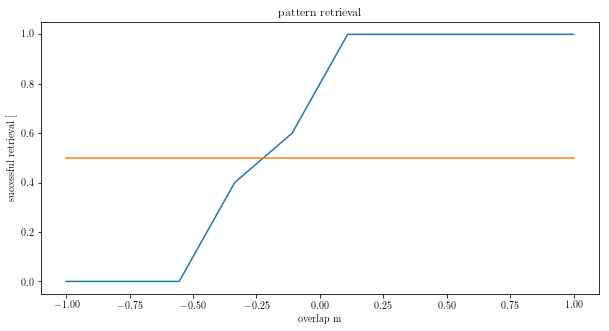

In [41]:
# check that spurious states disappear at T=0.46


## Robustness to brain damage
Set a fraction of the synaptic weights to zero, see how the network performs!

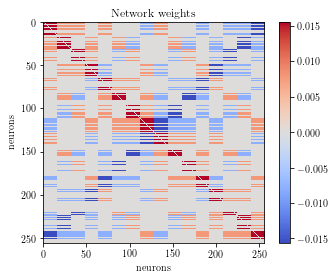

[ 0.453125  0.109375  0.015625 -0.046875]
[ 0.125     0.4375    0.078125 -0.03125 ]
[ 0.0625    0.109375  0.40625  -0.078125]
[ 0.046875  0.046875 -0.03125   0.359375]


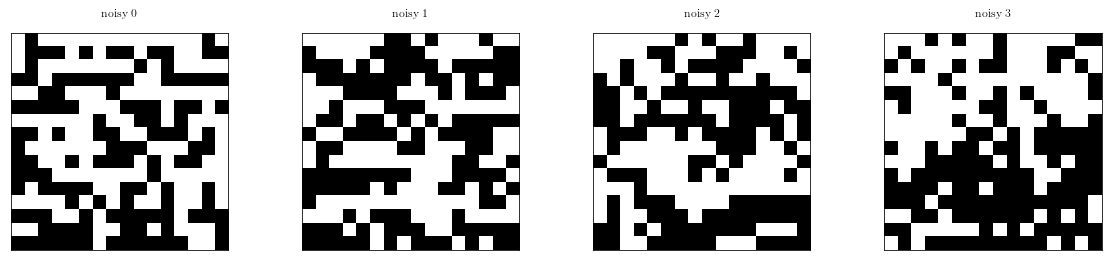

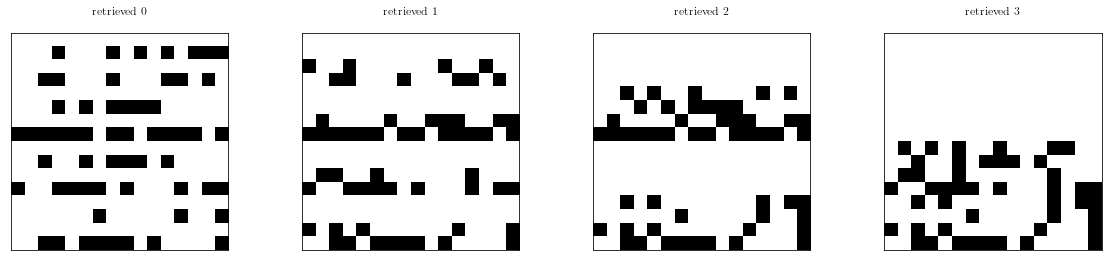

In [43]:

plotweights(allweightsDamage,file="hopfield_weights_damaged.png")

# noisify each pattern

fig,ax=plt.subplots(1,4,figsize=(20,4))
for i in range(npatterns):
    plotpattern(noisy_patterns[i],ax[i],title='noisy %s' % i)

plt.savefig("hopfield_orth4_noisy.png")

fig,ax=plt.subplots(1,4,figsize=(20,4))
for i in range(npatterns):
    plotpattern(recovered_pattern[i],ax[i],title='retrieved %s' % i)
plt.savefig("hopfield_orth4_retrieval.png")